In [1]:
# Check if packages are installed and if not, install
!pip install -U shap catboost vaderSentiment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 9.0 MB/s eta 0:00:00


In [2]:
import seaborn as sns
from catboost import CatBoostClassifier, CatBoostRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import time
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import tree


from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, r2_score


import shap

# from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/MyDrive/shohei-cleaned-gptig.csv')
# df = df.head(100)

In [ ]:
# df_en = df.copy()

# df_en[['pro_dodgers', 'likely_country']] = df_en[['pro_dodgers', 'likely_country']].replace([np.inf, -np.inf], np.nan)

# # Drop rows where 'pro_dodgers' or 'likely_country' have NaN values
# df_en = df_en.dropna(subset=['pro_dodgers', 'likely_country'])


In [5]:
# Converting labels to str so it's seen as categorical
df['post_owner_label'] = df['post_owner_label'].astype(str)


In [10]:
# Vader sentiment analyzer and saving only compound scores
vader_analyzer = SentimentIntensityAnalyzer()


df["vaderSent"] = df["en_text"].apply(lambda x: vader_analyzer.polarity_scores(x))
df['vadercompound'] = df['vaderSent'].apply(lambda x: x['compound'])


In [11]:
df_jp = df[(df['lang'] == 'ja') ]


df_kr = df[(df['lang'] == 'ko') ]

df_zh = df[(df['lang'] == 'zh') ]


df_es = df[(df['lang'] == 'es') ]


df_jpam = df[(df['is_jpam'] == 1) ]

df_koram = df[(df['is_koram'] == 1) ]

df_zham = df[(df['is_cham'] == 1) ]

In [ ]:
df.columns


Index(['content_type', 'creation_time', 'hashtags', 'id', 'lang',
       'post_owner.type', 'post_owner.id', 'post_owner.name',
       'post_owner.username', 'statistics.comment_count',
       'statistics.like_count', 'statistics.views', 'text', 'log10_likes',
       'post_owner_label', 'content_type_label', 'hashtag_count', 'username',
       'name_origin', 'is_cham', 'is_koram', 'is_jpam', 'is_aam', 'is_hl',
       'en_text', 'vaderSent', 'vadercompound'],
      dtype='object')

In [ ]:
df['post_owner_label'].value_counts() # 0 is business page vs 1 is profile

,count
post_owner_label,
1,16434
2,6810


In [15]:
groups = [df, df_jp, df_kr, df_zh , df_es, df_jpam , df_koram , df_zham]

In [16]:
n = 0

x_cols = ['content_type_label','post_owner_label', 'vadercompound',
          'hashtag_count','lang']
X = groups[n][x_cols]
y = groups[n]['log10_likes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
categorical_features = ['post_owner_label', 'content_type_label', 'lang']
X_train[categorical_features] = X_train[categorical_features].astype('object')
X_test[categorical_features] = X_test[categorical_features].astype('object')

# Define the CatBoost Regressor
catboost_model = CatBoostRegressor(iterations=1000,
                                   learning_rate=0.05,
                                   depth=6,
                                   verbose=100)

# Train the model
catboost_model.fit(X_train, y_train,
                   eval_set=(X_test, y_test),
                   cat_features=categorical_features,
                   plot=True)

# Make predictions on the test set
y_pred_cb = catboost_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_cb)
r2 = r2_score(y_test, y_pred_cb)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8170096	test: 0.8223127	best: 0.8223127 (0)	total: 70.7ms	remaining: 1m 10s
100:	learn: 0.7180023	test: 0.7285805	best: 0.7285805 (100)	total: 4.05s	remaining: 36.1s
200:	learn: 0.7088523	test: 0.7231383	best: 0.7231313 (198)	total: 5.87s	remaining: 23.3s
300:	learn: 0.7001933	test: 0.7183203	best: 0.7183203 (300)	total: 7.1s	remaining: 16.5s
400:	learn: 0.6950429	test: 0.7164114	best: 0.7164114 (400)	total: 8.17s	remaining: 12.2s
500:	learn: 0.6910231	test: 0.7146605	best: 0.7146605 (500)	total: 9.27s	remaining: 9.24s
600:	learn: 0.6877652	test: 0.7136163	best: 0.7135885 (588)	total: 10.4s	remaining: 6.9s
700:	learn: 0.6847241	test: 0.7130378	best: 0.7130300 (698)	total: 11.9s	remaining: 5.06s
800:	learn: 0.6822262	test: 0.7124688	best: 0.7124688 (800)	total: 16.4s	remaining: 4.07s
900:	learn: 0.6797644	test: 0.7117609	best: 0.7117609 (900)	total: 18.6s	remaining: 2.05s
999:	learn: 0.6777022	test: 0.7114883	best: 0.7114664 (996)	total: 19.8s	remaining: 0us

bestTest = 0.71

Text(0.5, 1.0, 'SHAP Summary Plot for All Posts')

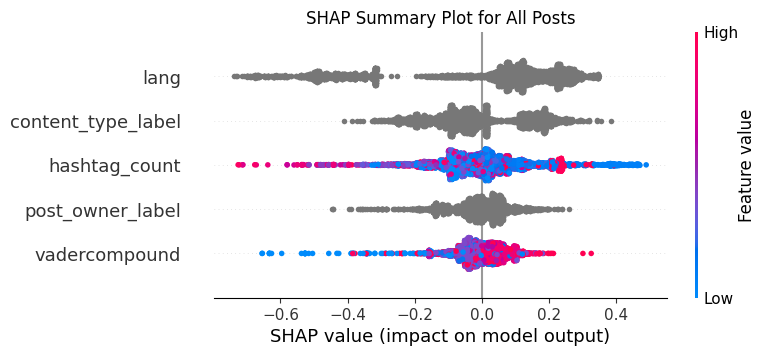

In [19]:
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_test)

# Generate SHAP summary plot
shap.summary_plot(shap_values, X_test, show=False)  # Avoid showing interactively in a loop
plt.title("SHAP Summary Plot for All Posts")


In [ ]:
# # Function to train and evaluate the CatBoost model and generate SHAP plots for a given language
# def run_catboost_with_shap(data, language, x_cols, target_col, categorical_features):
#     print(f"\nRunning model for language: {language}")

#     # Filter the dataset for the given language
#     df_subset = data[data['language'] == language]

#     # Split into X (features) and y (target)
#     X = df_subset[x_cols]
#     y = df_subset[target_col]

#     # Ensure all categorical columns are encoded as 'object'
#     X[categorical_features] = X[categorical_features].astype('object')

#     # Split into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # Define the CatBoost Regressor
#     catboost_model = CatBoostRegressor(iterations=1000,
#                                        learning_rate=0.05,
#                                        depth=6,
#                                        verbose=100)

#     # Train the model
#     catboost_model.fit(X_train, y_train,
#                        eval_set=(X_test, y_test),
#                        cat_features=categorical_features,
#                        plot=False)

#     # Make predictions on the test set
#     y_pred_cb = catboost_model.predict(X_test)

#     # Evaluate the model
#     mse = mean_squared_error(y_test, y_pred_cb)
#     r2 = r2_score(y_test, y_pred_cb)
#     print(f"Mean Squared Error: {mse}")
#     print(f"R² Score: {r2}")

#     # Compute SHAP values
#     explainer = shap.TreeExplainer(catboost_model)
#     shap_values = explainer.shap_values(X_test)

#     # Generate SHAP summary plot
#     print(f"Generating SHAP summary plot for language: {language}")
#     shap.summary_plot(shap_values, X_test, show=False)  # Avoid showing interactively in a loop
#     plt.title(f"SHAP Summary Plot for {language}")
#     plt.savefig(f"shap_summary_{language}.png")  # Save the plot for each language
#     plt.clf()  # Clear the figure for the next plot

#     return catboost_model

# # Define columns and categorical features
# x_cols = ['post_owner_label', 'likely_country', 'pro_ohtani', 'pro_dodgers', 'language', 'content_type']
# target_col = 'log10_likes'
# categorical_features = ['post_owner_label', 'likely_country', 'language']

# # Run tests for each language and generate SHAP plots
# languages = ['English', 'Spanish', 'Traditional Chinese']
# models = {}

# for lang in languages:
#     models[lang] = run_catboost_with_shap(df_en, lang, x_cols, target_col, categorical_features)


In [ ]:
# # Define columns and categorical features
# x_cols = ['post_owner_label', 'likely_country', 'pro_ohtani', 'pro_dodgers', 'language', 'content_type']
# target_col = 'log10_likes'
# categorical_features = ['post_owner_label', 'likely_country', 'language']

<ipython-input-84-efbd4d74e0d7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[categorical_features] = X[categorical_features].astype('object')


0:	learn: 0.9210957	test: 0.6504792	best: 0.6504792 (0)	total: 1.58ms	remaining: 1.58s
100:	learn: 0.8087991	test: 0.6456364	best: 0.6287111 (20)	total: 120ms	remaining: 1.07s
200:	learn: 0.7362755	test: 0.6816219	best: 0.6287111 (20)	total: 291ms	remaining: 1.16s
300:	learn: 0.6912951	test: 0.7049566	best: 0.6287111 (20)	total: 403ms	remaining: 936ms
400:	learn: 0.6659298	test: 0.7155613	best: 0.6287111 (20)	total: 584ms	remaining: 873ms
500:	learn: 0.6504886	test: 0.7249702	best: 0.6287111 (20)	total: 684ms	remaining: 681ms
600:	learn: 0.6365547	test: 0.7366255	best: 0.6287111 (20)	total: 775ms	remaining: 515ms
700:	learn: 0.6229134	test: 0.7430427	best: 0.6287111 (20)	total: 958ms	remaining: 408ms
800:	learn: 0.6057873	test: 0.7569170	best: 0.6287111 (20)	total: 1.02s	remaining: 255ms
900:	learn: 0.5924078	test: 0.7666126	best: 0.6287111 (20)	total: 1.18s	remaining: 129ms
999:	learn: 0.5806649	test: 0.7800399	best: 0.6287111 (20)	total: 1.25s	remaining: 0us

bestTest = 0.6287111473


Text(0.5, 1.0, 'SHAP Summary Plot for English')

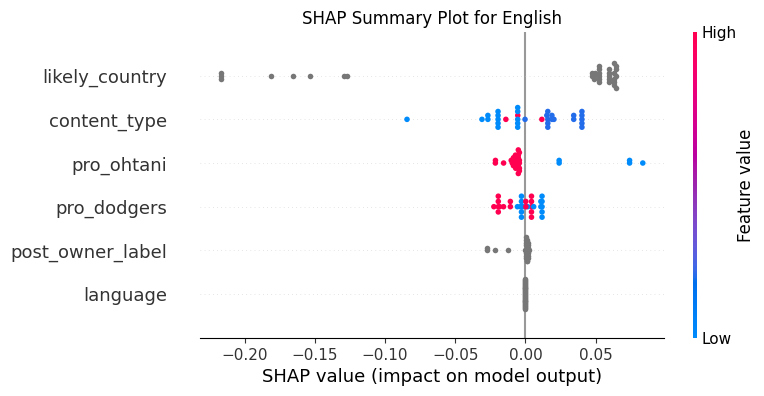

In [ ]:


# Filter the dataset for the given language
df_subset = df_en[df_en['language'] == 'English']

# Split into X (features) and y (target)
X = df_subset[x_cols]
y = df_subset[target_col]

# Ensure all categorical columns are encoded as 'object'
X[categorical_features] = X[categorical_features].astype('object')

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CatBoost Regressor
catboost_model = CatBoostRegressor(iterations=1000,
                                    learning_rate=0.05,
                                    depth=6,
                                    verbose=100)

# Train the model
catboost_model.fit(X_train, y_train,
                    eval_set=(X_test, y_test),
                    cat_features=categorical_features,
                    plot=False)

# Make predictions on the test set
y_pred_cb = catboost_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_cb)
r2 = r2_score(y_test, y_pred_cb)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Compute SHAP values
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_test)

# Generate SHAP summary plot
shap.summary_plot(shap_values, X_test, show=False)  # Avoid showing interactively in a loop
plt.title("SHAP Summary Plot for English")





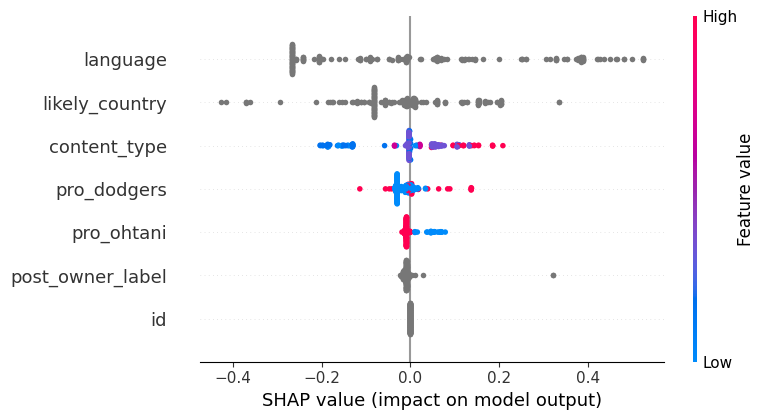

In [ ]:

explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_test)


shap.summary_plot(shap_values, X_test)

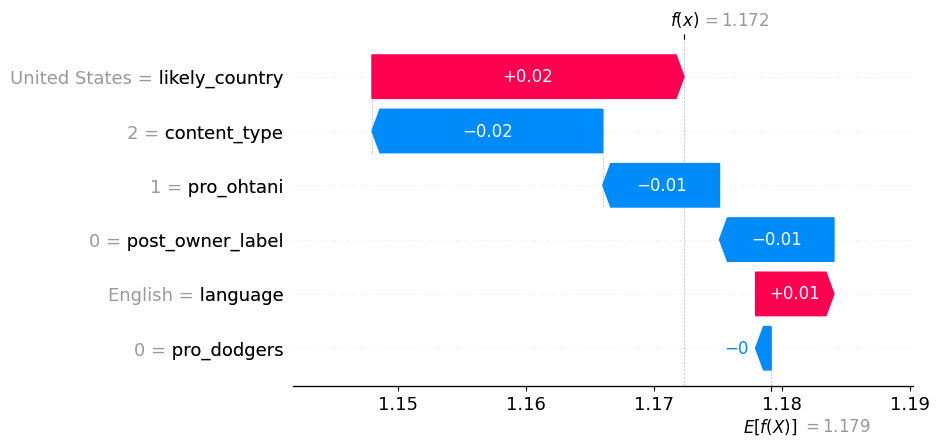

In [ ]:
instance_n = 2
shap.waterfall_plot(shap.Explanation(values=shap_values[instance_n],
                                      base_values=explainer.expected_value,
                                      data=X_test.iloc[instance_n]))
plt.show()

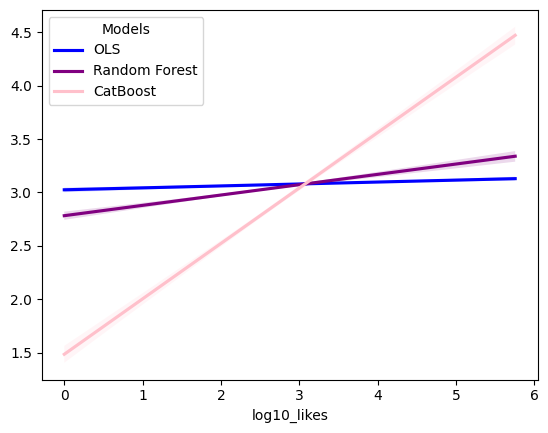

In [ ]:
# sns.regplot(x=y_test, y=y_pred, scatter=False, label='OLS', color='blue')
# sns.regplot(x=y_test, y=y_pred_rf, scatter=False, label='Random Forest', color='purple')
# sns.regplot(x=y_test, y=y_pred_cb, scatter=False, label='CatBoost', color='pink')

# plt.legend(title='Models')


# plt.show()